In [ ]:
#@title Setup
!git clone https://github.com/kakaobrain/minDALL-E
%cd /content/minDALL-E
#Since some version problems, I need to rewrite the reqirements file to fix it.
with open('requirements.txt', 'w') as f:
  f.write(
'''torch==1.7.1
torchtext==0.8.1
torchvision>=0.8.2
tokenizers>=0.10.2
pyflakes>=2.2.0
tqdm>=4.46.0
pytorch-lightning>=1.5
einops
omegaconf
git+https://github.com/openai/CLIP.git
matplotlib''')
!pip install -r requirements.txt
import os
import sys
import argparse
import clip
import numpy as np
from PIL import Image

sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))

from dalle.models import Dalle
from dalle.utils.utils import set_seed, clip_score

Cloning into 'minDALL-E'...
remote: Enumerating objects: 120, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 120 (delta 7), reused 3 (delta 3), pack-reused 110
Receiving objects: 100% (120/120), 45.66 MiB | 38.42 MiB/s, done.
Resolving deltas: 100% (31/31), done.
/content/minDALL-E
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-it_lbhf7
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-it_lbhf7
     |████████████████████████████████| 776.8 MB 17 kB/s 
     |████████████████████████████████| 7.0 MB 61.4 MB/s 
     |████████████████████████████████| 6.6 MB 47.6 MB/s 
     |████████████████████████████████| 66 kB 5.8 MB/s 
     |████████████████████████████████| 700 kB 54.6 MB/s 
     |████████████████████████████████| 79 kB 8.7 MB/s 
     |████████████████████████████████

In [ ]:
#@title Set the paramenters and load the model
n = num_candidates = 16
softmax_temperature = 1.0
top_k = 192
top_p = None #help='0.0 <= top-p <= 1.0'
seed = 0
# Setup
assert top_k <= 256, "It is recommended that top_k is set lower than 256."
set_seed(seed)
device = "cuda:0"  #Need to open a notebook with GPU
model = Dalle.from_pretrained('minDALL-E/1.3B')  # This will automatically download the pretrained model.
model.to(device=device)

100%|█████████████████████████████████████| 4.72G/4.72G [04:46<00:00, 17.7MiB/s]
extracting: ./1.3B/tokenizer/bpe-16k-vocab.json (size:0MB): 100%|██████████| 7/7 [00:50<00:00,  7.20s/it]


/root/.cache/minDALL-E/1.3B/tokenizer successfully restored..
/root/.cache/minDALL-E/1.3B/stage1_last.ckpt successfully restored..
/root/.cache/minDALL-E/1.3B/stage2_last.ckpt succesfully restored..


Dalle(
  (stage1): VQGAN(
    (encoder): Encoder(
      (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (down): ModuleList(
        (0): Module(
          (block): ModuleList(
            (0): ResnetBlock(
              (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
              (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            )
            (1): ResnetBlock(
              (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
              (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(

In [ ]:
#@title Input prompts
prompt = 'Flower Field' #@param {type:"string"}

100%|██████████| 256/256 [00:23<00:00, 10.84it/s]
100%|███████████████████████████████████████| 338M/338M [00:08<00:00, 40.8MiB/s]


[12 13  4  5 11  8 10  0  3 15  9  1 14  2  6  7] (16, 256, 256, 3)


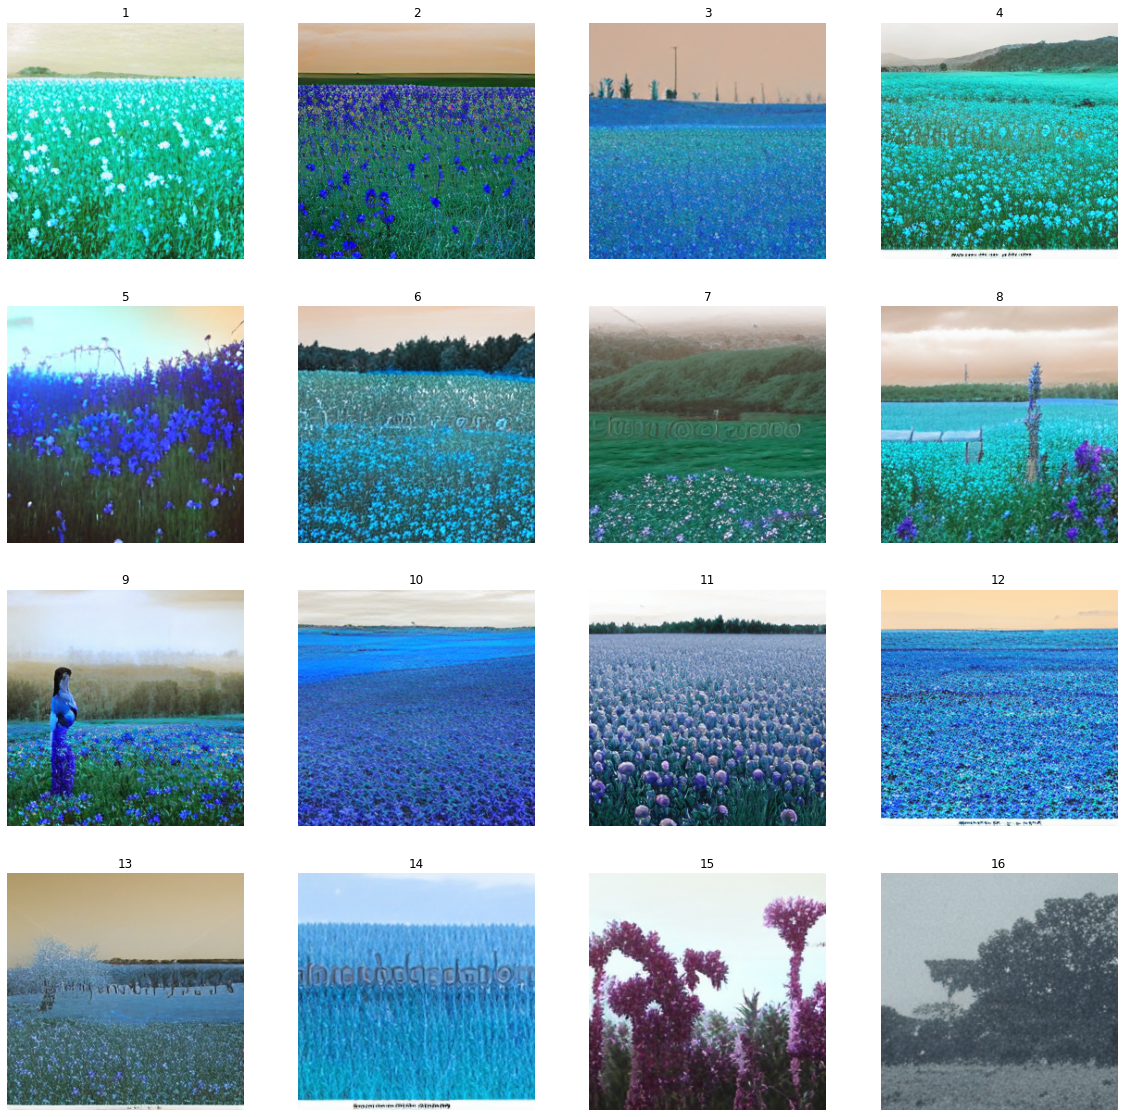

In [ ]:
#@title Generate the images...
# Sampling
images = model.sampling(prompt=prompt,
                        top_k=top_k,
                        top_p=top_p,
                        softmax_temperature=softmax_temperature,
                        num_candidates=num_candidates,
                        device=device).cpu().numpy()
images = np.transpose(images, (0, 2, 3, 1))
# CLIP Re-ranking
model_clip, preprocess_clip = clip.load("ViT-B/32", device=device)
model_clip.to(device=device)
rank = clip_score(prompt=prompt,
                  images=images,
                  model_clip=model_clip,
                  preprocess_clip=preprocess_clip,
                  device=device)

# Save images
images = images[rank]
print(rank, images.shape)
if not os.path.exists('./figures'):
    os.makedirs('./figures')
for i in range(min(16, num_candidates)):
    im = Image.fromarray((images[i]*255).astype(np.uint8))
    im.save(f'./figures/{prompt}_{i}.png')
from matplotlib import pyplot as plt
%matplotlib inline
import cv2
  
# create figure
fig = plt.figure(figsize=(20, 20))
  
# setting values to rows and column variables
rows = 4
columns = 4


p = r"/content/minDALL-E/figures/"


for i in range(n):
  img = cv2.imread(p + prompt + '_' + str(i) +'.png')
  fig.add_subplot(rows, columns, i+1)
  plt.imshow(img)
  plt.axis('off')
  plt.title(f'{i+1}')

In [ ]:
#@title Zip and Download the figures
!zip -r /content/minDALL-E/figures.zip /content/minDALL-E/figures
from google.colab import files
files.download('/content/minDALL-E/figures.zip')

  adding: content/minDALL-E/figures/ (stored 0%)
  adding: content/minDALL-E/figures/Flower Field_9.png (deflated 0%)
  adding: content/minDALL-E/figures/Flower Field_15.png (deflated 0%)
  adding: content/minDALL-E/figures/Flower Field_4.png (deflated 0%)
  adding: content/minDALL-E/figures/Flower Field_6.png (deflated 0%)
  adding: content/minDALL-E/figures/Flower Field_12.png (deflated 0%)
  adding: content/minDALL-E/figures/Flower Field_3.png (deflated 0%)
  adding: content/minDALL-E/figures/Flower Field_10.png (deflated 0%)
  adding: content/minDALL-E/figures/Flower Field_1.png (deflated 0%)
  adding: content/minDALL-E/figures/Flower Field_0.png (deflated 0%)
  adding: content/minDALL-E/figures/Flower Field_14.png (deflated 0%)
  adding: content/minDALL-E/figures/Flower Field_7.png (deflated 0%)
  adding: content/minDALL-E/figures/Flower Field_2.png (deflated 0%)
  adding: content/minDALL-E/figures/Flower Field_8.png (deflated 0%)
  adding: content/minDALL-E/figures/Flower Field_1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>